In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Add, Flatten, Dense
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from keras.utils import np_utils
from keras.datasets import cifar10

In [20]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10. load_data ()
print ("Train samples : ", x_train. shape, y_train. shape)
print("Test samples:", x_test. shape, y_test. shape)

Train samples :  (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


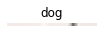

In [21]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
#show random images from training data
cols = 8
rows = 2
fig = plt.figure(figsize = (2*cols-1, 2.5*rows-1))
for i in range(cols) :
    for j in range( rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i*rows+j+1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :1])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
        plt.show()

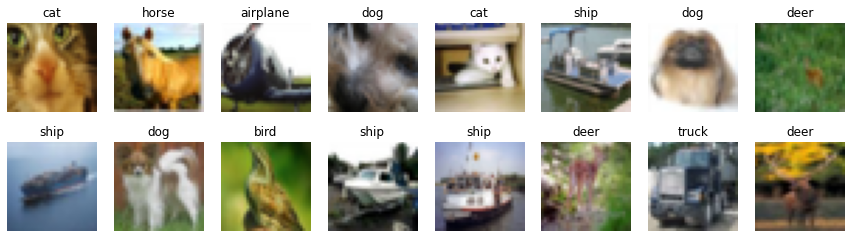

In [22]:
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",  "dog", "frog", "horse", "ship", "truck"]

# show random images from train
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

In [23]:
X_train = x_train.astype('float32')
X_test = x_test.astype('float32')
X_train/=255
X_test/=255
Y_train = np_utils.to_categorical(y_train, len(cifar10_classes))
Y_test = np_utils.to_categorical (y_test, len(cifar10_classes))

x_val = X_train[: 10000]
partial_x_train = X_train[10000:]
y_val = Y_train[:10000]
partial_y_train = Y_train[10000:]

gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3, height_shift_range=0.08, zoom_range=0.08)
val_gen = ImageDataGenerator()
train_generator = gen.flow(partial_x_train, partial_y_train, batch_size=32)
val_generator = val_gen.flow(x_val, y_val, batch_size=32)

In [24]:

X_input = Input((32,32,3))
X = ZeroPadding2D (padding= (3, 3), data_format=None)(X_input)
X = Conv2D(64, (7, 7), strides = (2, 2), name ='conv1', kernel_initializer = GlorotUniform(seed=0))(X)
X = BatchNormalization (axis = 3, name = "bn_conv1")(X)
X = Activation ( "relu")(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

# Stage 2 for ResNet
X_shortcut = X
X = ZeroPadding2D(padding=(1, 1), data_format=None)(X)
X = Conv2D (64, (3, 3), strides = (1, 1), name = 'conv2', kernel_initializer = GlorotUniform(seed=0))(X)
X = BatchNormalization(axis = 3, name = "bn_conv2")(X)
X = Activation('relu')(X)
X = ZeroPadding2D(padding= (1, 1), data_format=None)(X)
X = Conv2D(64, (3, 3), strides = (1, 1), name = 'conv3', kernel_initializer = GlorotUniform(seed=0))(X)
X = BatchNormalization(axis = 3, name = "bn_conv3")(X)

#Add X_shortcut before doing final activation
X = Add()([X, X_shortcut])
X = Activation("relu")(X)
X = Flatten()(X)
X = Dense(NUM_CLASSES, activation= 'softmax', name='fc'+str(NUM_CLASSES), kernel_initializer = GlorotUniform(seed=0 ))(X)

In [25]:
model = Model(inputs = X_input, outputs = X, name= 'ResNet50')
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 38, 38, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [26]:
model.compile(loss = "categorical_crossentropy", optimizer=Adam(), metrics=['accuracy'])
model.fit_generator(train_generator, steps_per_epoch=4000//32, epochs=10, validation_data=val_generator, validation_steps=1000//32)
score = model.evaluate(X_test, Y_test)
print()
print("Test accuracy : ",score [1])

Epoch 1/10
125/125 [==============================] - 5s 38ms/step - loss: 2.2606 - accuracy: 0.3045 - val_loss: 2.3359 - val_accuracy: 0.2248
Epoch 2/10
125/125 [==============================] - 5s 41ms/step - loss: 1.8670 - accuracy: 0.3740 - val_loss: 2.3621 - val_accuracy: 0.2137
Epoch 3/10
125/125 [==============================] - 6s 49ms/step - loss: 1.7085 - accuracy: 0.4055 - val_loss: 1.8210 - val_accuracy: 0.3538
Epoch 4/10
125/125 [==============================] - 6s 49ms/step - loss: 1.5819 - accuracy: 0.4397 - val_loss: 1.5892 - val_accuracy: 0.4244
Epoch 5/10
125/125 [==============================] - 6s 47ms/step - loss: 1.5615 - accuracy: 0.4588 - val_loss: 1.4867 - val_accuracy: 0.4738
Epoch 6/10
125/125 [==============================] - 5s 42ms/step - loss: 1.4716 - accuracy: 0.4770 - val_loss: 1.6963 - val_accuracy: 0.4153
Epoch 7/10
125/125 [==============================] - 5s 43ms/step - loss: 1.4623 - accuracy: 0.4852 - val_loss: 1.6065 - val_accuracy: 0.4425

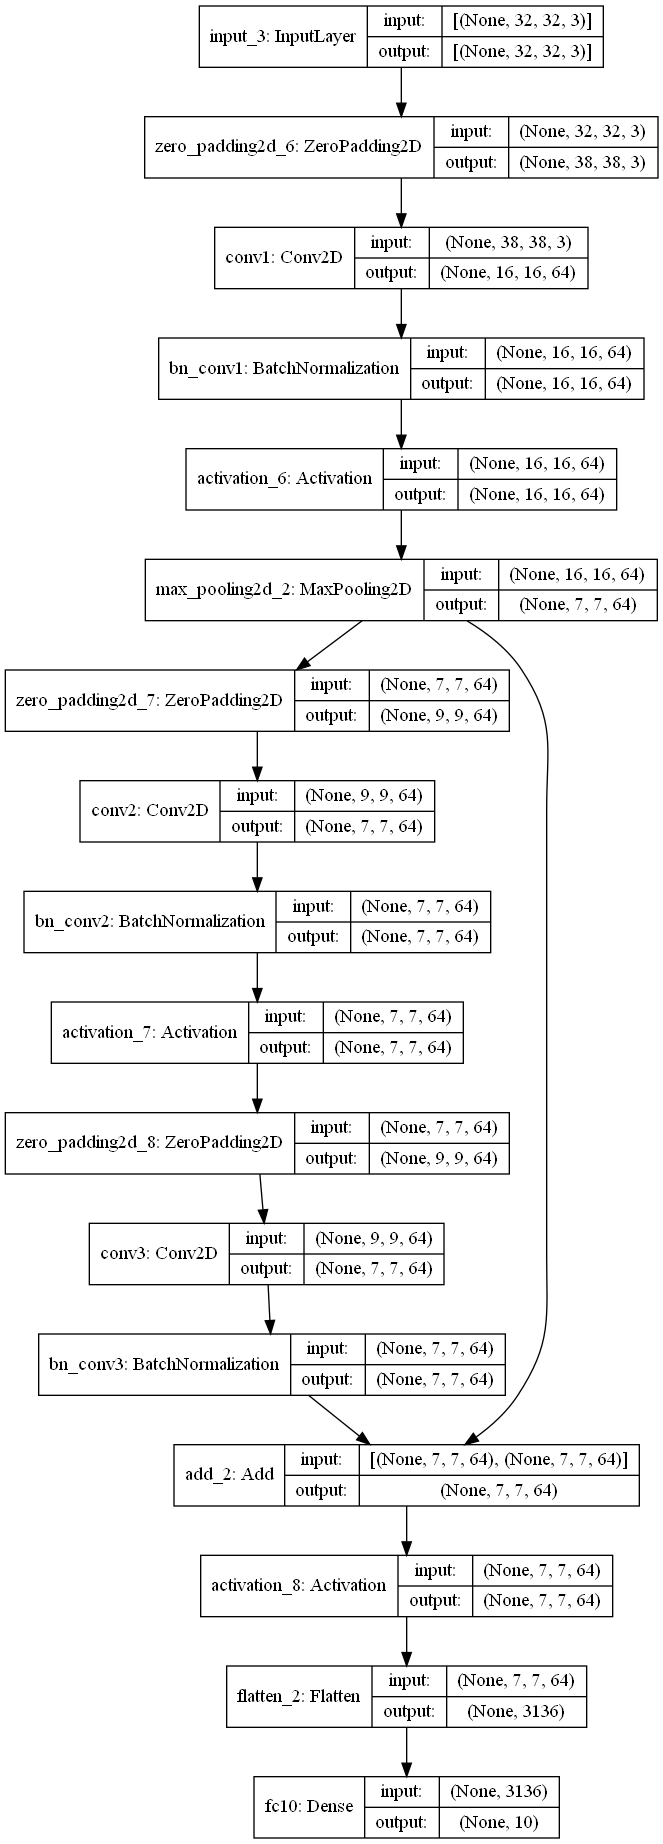

In [27]:
plot_model(model, show_shapes = True)